In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json

scala_version = '2.12'  # your scala version
spark_version = '3.5.0' # your spark version
packages = [
    f'org.apache.spark:spark-sql-kafka-0-10_{scala_version}:{spark_version}',
    'org.apache.kafka:kafka-clients:2.8.0' #your kafka version
]
spark = SparkSession.builder.master("local").appName("kafka-example").config("spark.jars.packages", ",".join(packages)).getOrCreate()
spark

In [2]:
from time import sleep
from IPython.display import display, clear_output
from pyspark.sql.functions import regexp_extract
from pyspark.sql.functions import col, split
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd

In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
Aactual = spark.read.csv("./data/AAPL/actual.csv", header=True, inferSchema=True)
Aactual_pd = Aactual.toPandas()

In [5]:
topic_name = 'AAPL'
kafka_server = 'localhost:9092'

AkafkaDf = spark.readStream.format("kafka").option("kafka.bootstrap.servers", kafka_server).option("subscribe", topic_name).load()

In [6]:
Adf = AkafkaDf.selectExpr("CAST(value AS STRING)").select(split("value", ",").alias("csv_values")) \
    .selectExpr("csv_values[0] as prediction")
Adf1 = Adf.alias("copied")

In [7]:
# Tạo một cột mới "number" bằng cách tách số từ cột "value"
Adf1 = Adf1.withColumn("number", regexp_extract(Adf["prediction"], r'(\d+\.?\d*)', 1))
Adf1 = Adf1.withColumn("number", col("number").cast(DoubleType()))

In [8]:
# Xuất streaming ra màn hình
Aquery = Adf1.writeStream.format("memory").outputMode("append").queryName("streaming_query")
Aquery2 = Aquery.start()

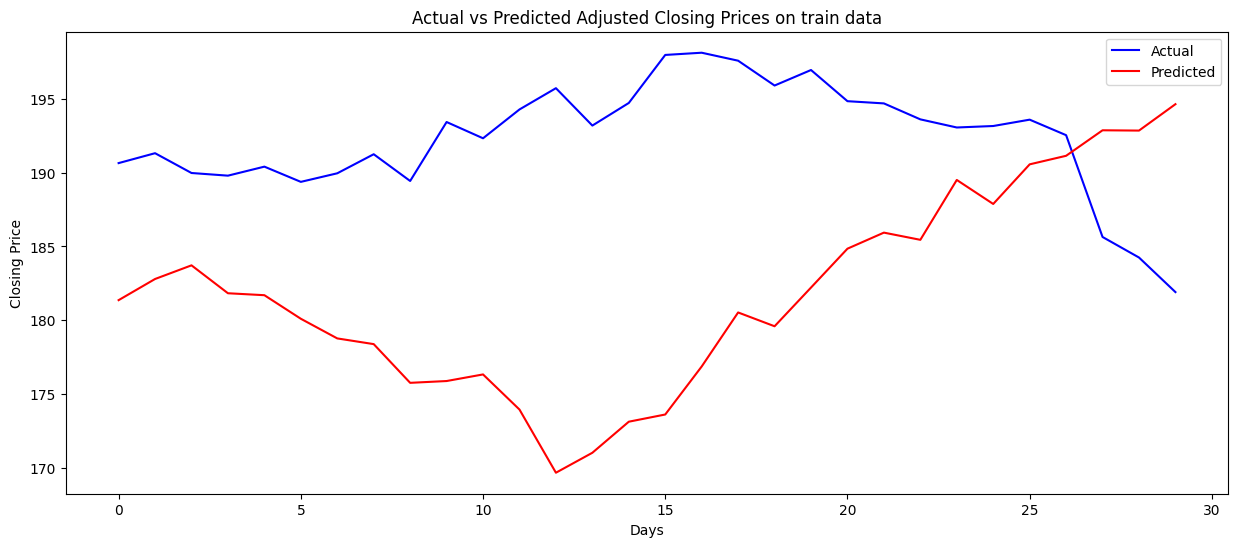

break


In [9]:
# Vòng lặp để vẽ và cập nhật biểu đồ AAPL
for x in range(0, 2000):
    try:
        # Lấy dữ liệu từ tên truy vấn streaming
        result2 = spark.sql(f"SELECT * from {Aquery2.name}")
        data = result2.toPandas()

        #Vẽ biểu đồ thể hiện sự biến đổi giá cổ phiếu qua các năm.
        plt.figure(figsize=(15,6))
        plt.plot(Aactual_pd["Close"], label='Actual', color='blue')
        plt.plot(data["number"], label='Predicted', color='red')
        plt.title('Actual vs Predicted Adjusted Closing Prices on train data')
        plt.xlabel('Days')
        plt.ylabel('Closing Price')
        plt.legend()
        plt.show()
        sleep(5)
        clear_output(wait=True)
    except KeyboardInterrupt:
        print("break")
        break

plt.show()

In [10]:
Aquery2.stop()

In [11]:
Nactual = spark.read.csv("./data/NVDA/actual.csv", header=True, inferSchema=True)
Nactual_pd = Nactual.toPandas()

In [12]:
topic_name = 'NVDA'
kafka_server = 'localhost:9092'

NkafkaDf = spark.readStream.format("kafka").option("kafka.bootstrap.servers", kafka_server).option("subscribe", topic_name).load()

In [13]:
Ndf = NkafkaDf.selectExpr("CAST(value AS STRING)").select(split("value", ",").alias("csv_values")) \
    .selectExpr("csv_values[0] as prediction")
Ndf1 = Ndf.alias("copied")

In [14]:
Ndf1 = Ndf1.withColumn("number", regexp_extract(Ndf["prediction"], r'(\d+\.?\d*)', 1))
Ndf1 = Ndf1.withColumn("number", col("number").cast(DoubleType()))

In [15]:
# Xuất streaming ra màn hình
Nquery = Ndf1.writeStream.format("memory").outputMode("append").queryName("streaming_query")
Nquery2 = Nquery.start()

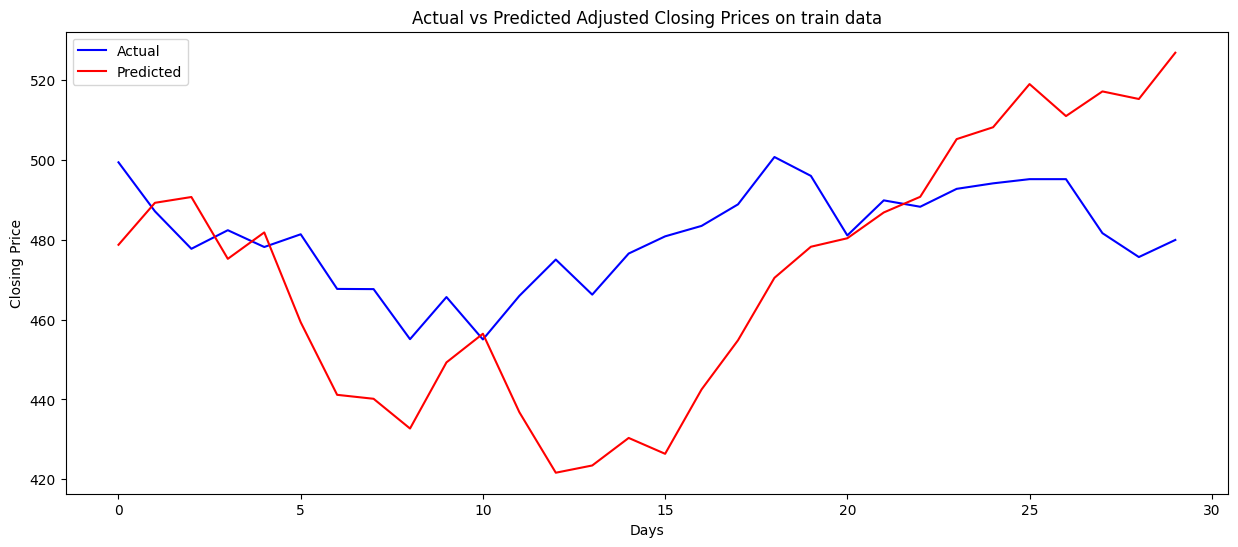

break


In [16]:
# Vòng lặp để vẽ và cập nhật biểu đồ NVDA
for x in range(0, 2000):
    try:
        # Lấy dữ liệu từ tên truy vấn streaming
        result3 = spark.sql(f"SELECT * from {Nquery2.name}")
        data2 = result3.toPandas()

        #Vẽ biểu đồ thể hiện sự biến đổi giá cổ phiếu qua các năm.
        plt.figure(figsize=(15,6))
        plt.plot(Nactual_pd["Close"], label='Actual', color='blue')
        plt.plot(data2["number"], label='Predicted', color='red')
        plt.title('Actual vs Predicted Adjusted Closing Prices on train data')
        plt.xlabel('Days')
        plt.ylabel('Closing Price')
        plt.legend()
        plt.show()
        sleep(5)
        clear_output(wait=True)
    except KeyboardInterrupt:
        print("break")
        break

plt.show()

In [17]:
Nquery2.stop()